In [867]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
%matplotlib inline
import torch.nn.functional as F
mean=np.array([0,0,0])
cov=np.array([[1,0.8,0.8],[0.8,1,0.8],[0.8,0.8,1]])
training_data=[]
testing_data=[]

for i in range(800):
    x=np.random.multivariate_normal(mean,cov)
    x=np.reshape(x,(3,1))
    training_data.append(x)

for i in range(200):
    x=np.random.multivariate_normal(mean,cov)
    x=np.reshape(x,(3,1))
    testing_data.append(x)

training_data=training_data-np.min(training_data)
training_data=training_data/np.max(training_data)

testing_data=testing_data-np.min(testing_data)
testing_data=testing_data/np.max(testing_data)

In [868]:
def sigmoid(x):
    return(1/(1+np.exp(-1*x)))

def sigmoid_derivative(x):
    sig=sigmoid(x)
    s=sig*(1-sig)
    assert s.shape==(3,1)
    return(s)

def relu(x):
    x[x<=0]=0
    return(x)

def relu_derivative(x):
    x[x<=0]=0
    x[x>0]=1
    return(x)

def calc_grad(w1,w2,b1,b2,x):

    a1=np.dot(w1,x)+b1
    assert a1.shape==(2,1)
    
    z1=relu(a1)
    assert z1.shape==(2,1)
    
    a2=np.matmul(w2,z1)+b2
    assert a2.shape==(3,1)
    
    z2=sigmoid(a2)
    assert z2.shape==(3,1)
    x_hat=z2
    
    grad_b1=np.zeros((2,1))
    vari=2*(x_hat-x)*sigmoid_derivative(a2)
    grad_b2=vari
    grad_w2=np.dot(vari,z1.T)
    
    act2der=sigmoid_derivative(a2)
    act1der=relu_derivative(a1)
    m1=np.dot(act1der,act2der.T)   #2x3

    m2=2*w2*(x_hat-x)              #3x2
    m2=m2.T
    
    
    vari1=m1*m2
    grad_w1=vari1*x.T
    
    x=[grad_w2,grad_b2,grad_w1,grad_b1]

    return(x)  

def get_pred(w1,w2,b1,b2,x):
    a1=np.matmul(w1,x)+b1
    z1=relu(a1)
    a2=np.matmul(w2,z1)+b2
    z2=sigmoid(a2)
    x_hat=z2
    
    return(x_hat)

In [869]:
#trainable parameters
w1=np.random.rand(2,3)      #weights from input to hidden layer
w2=np.random.rand(3,2)      #weights from hidden layer to last
b1=np.random.rand(2,1)      #bias of hidden layer
b2=np.random.rand(3,1)      #bias of last layer


In [870]:
epoch=30
lr=0.05
train_iteration_vs_loss=[]
test_iteration_vs_loss=[]

for i in range(epoch):
    #testing
    train_loss=0
    
    for j in training_data:
        grad_w2,grad_b2,grad_w1,grad_b1=calc_grad(w1,w2,b1,b2,j)
        loss_vector=(get_pred(w1,w2,b1,b2,j)-j)**2
        train_loss+=np.mean(loss_vector)
        
        w2=w2-lr*grad_w2
        b2=b2-lr*grad_b2
        w1=w1-lr*grad_w1
        b1=b1-lr*grad_b1
    
    
    train_loss=train_loss/len(training_data)
    train_iteration_vs_loss.append((i+1,train_loss))
    
    #testing
    
    testing_loss=0

    for k in range(len(testing_data)):
        loss_vector=0
        j=testing_data[k]
        loss_vector=(get_pred(w1,w2,b1,b2,j)-j)**2
        testing_loss+=np.mean(loss_vector)
     
    testing_loss/=len(testing_data)
    test_iteration_vs_loss.append((i+1,testing_loss))


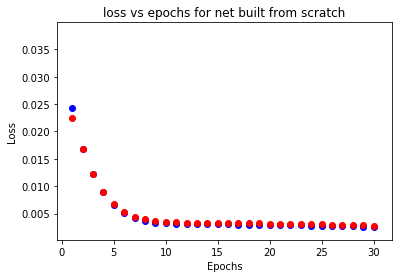

In [871]:
for i in range(len(train_iteration_vs_loss)):
    plt.scatter(train_iteration_vs_loss[i][0],train_iteration_vs_loss[i][1],c='b',label='training_loss')
    plt.scatter(test_iteration_vs_loss[i][0],test_iteration_vs_loss[i][1],c='r',label='testing_loss')
    
plt.title("loss vs epochs for net built from scratch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [872]:
class Net(nn.Module):
    def __init__(self,D_in,H,D_out):     #net is refrenced from in class notebook given
        super(Net,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.linear2=nn.Linear(H,D_out)

        
    def forward(self,x):
        x=F.relu(self.linear1(x))  
        x=torch.sigmoid(self.linear2(x))
        return x
    
model=Net(3,2,3)
model=model.float()
criterion=nn.MSELoss()


In [873]:
learning_rate=0.1
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs=30
net_train_iteration_vs_loss=[]
net_test_iteration_vs_loss=[]


for i in range(epochs):
    if(i%5==0):
        print(i)
        
    train_loss=0
    
    for j in training_data:
        optimizer.zero_grad()
        j=torch.from_numpy(j)
        j=torch.reshape(j,(1,3))
        j=j.float()
        pred=model(j)

        loss_vector=criterion(pred,j)
        loss_vector=loss_vector.float()

        train_loss+=loss_vector
        #train_loss= curr_loss.detach()
        
        loss_vector.backward()
        optimizer.step()

    train_loss/=len(training_data)
    net_train_iteration_vs_loss.append((i+1,train_loss))
    
    
    testing_loss=0

    for k in range(len(testing_data)):
        loss_vector=0
        j=testing_data[k]
        j=torch.from_numpy(j)
        j=torch.reshape(j,(1,3))
        j=j.float()
        pred=model(j)
        loss_vector=criterion(pred,j)
        loss_vector=loss_vector.float()
        #loss_vector= loss_vector.detach()
        testing_loss+=loss_vector

    testing_loss/=len(testing_data)
    net_test_iteration_vs_loss.append((i+1,testing_loss))


0
5
10
15
20
25


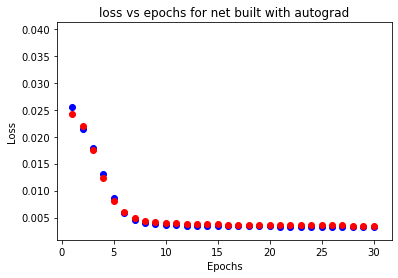

In [874]:
for i in range(len(net_train_iteration_vs_loss)):
    plt.scatter(net_train_iteration_vs_loss[i][0],net_train_iteration_vs_loss[i][1].detach(),c='b',label='training_loss')
    plt.scatter(net_test_iteration_vs_loss[i][0],net_test_iteration_vs_loss[i][1].detach(),c='r',label='testing_loss')
    
plt.title("loss vs epochs for net built with autograd")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()